# EnvErgo project
- [researchgate link](https://www.researchgate.net/project/Isokinetic-measurements-and-musculoskeletal-modelling-for-ergonomics)
- [github link](https://github.com/romainmartinez/envergo)

_Romain Martinez_

# Statistical Parametric Mapping

## Todos
- Region of interest in spm
- Do all permutations (`iterations=-1, force_iterations=True`)

## Data description
- 3 files for each position:
    1. `participant_position_CVP`: `Couple_ext`, `Couple_flex`, `Position`, `Vitese` (441, 1 each)
    2. `participant_position_Flex_meshdata`: `Angle4mesh` (1, 21), `Velocity4mesh` (1, 21), `torque4mesh`(21, 21)
    3. `participant_position_Ext_meshdata`: `Angle4mesh` (1, 21), `Velocity4mesh` (1, 21), `torque4mesh` (21, 21)
- We will use `Angle4mesh` (1, 21), `Velocity4mesh` (1, 21), `torque4mesh`(21, 21) to generate mesh and do the stats

In [1]:
import envergo
import os
import scipy.io as sio
import numpy as np; np.random.seed(0)
import spm1d
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = '/home/romain/Desktop/envergo'
files = os.listdir(data_path)

torque = {}

for ifile in files:
    if ifile.endswith('meshdata.mat'):
        participant, position, contraction, ext = ifile.split('_')

        mat = sio.loadmat(os.path.join(data_path, ifile))['Torque4mesh']
        if not position in torque:
            torque[position] = {}
        if contraction in torque[position]:
            torque[position][contraction] = np.dstack((torque[position][contraction], mat))
        else:
            torque[position][contraction] = mat

In [3]:
# create spm matrix (flatten 2D matrix to 1D vector)
angle, velocity, participant = torque['Abd90ER']['Ext'].shape
position = len(torque.keys())

participants, positions, y = ([] for i in range(3))

for iparticipant in range(participant):
    for iposition, position_name in enumerate(torque.keys()):
        participants.append(iparticipant + 1)
        positions.append(iposition + 1)
        y.append(torque[position_name]['Ext'][:, :, iparticipant].flatten())

participants, positions, y = [np.array(i) for i in [participants, positions, y]]
print('participant: {}'.format(participants))
print('position: {}'.format(positions))
print('y.shape: {}'.format(y.shape))

participant: [1 1 1 1 1 1 2 2 2 2 2 2]
position: [1 2 3 4 5 6 1 2 3 4 5 6]
y.shape: (12, 441)


In [4]:
def display_results(spm, drop_non_significative=False, title=None):
    print(spm)
    print(spm.clusters)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    
    # 1D representation
    spm.plot(ax=axs[0])
    spm.plot_p_values(ax=axs[0])
    spm.plot_threshold_label(ax=axs[0])
    axs[0].set_title('1D representation')
    
    # 2D representation
    z = spm.z.reshape([21, 21])
    zstar = spm.zstar
    if drop_non_significative:
        z[z < zstar] = np.nan
    
    plt.pcolor(z, cmap='viridis')

    # float to int
    envergo.util.axis2int()
    # add color bar
    plt.colorbar(pad=.08)

    plt.xlabel('Velocity')
    plt.ylabel('Angle')
    
    axs[1].set_title('2D representation')
    
    # aes
    fig.tight_layout()
    fig.suptitle(title, y=1.05, fontsize=15)
    sns.despine(offset=10)
    plt.show()

## One-way repeated-measures ANOVA (non-parametric)

SnPM{F} inference field
   SPM.effect         :  Main A
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4.79e+08 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  13.37511
   SPM.h0reject       :  False
   SPM.p              :  ()

[]


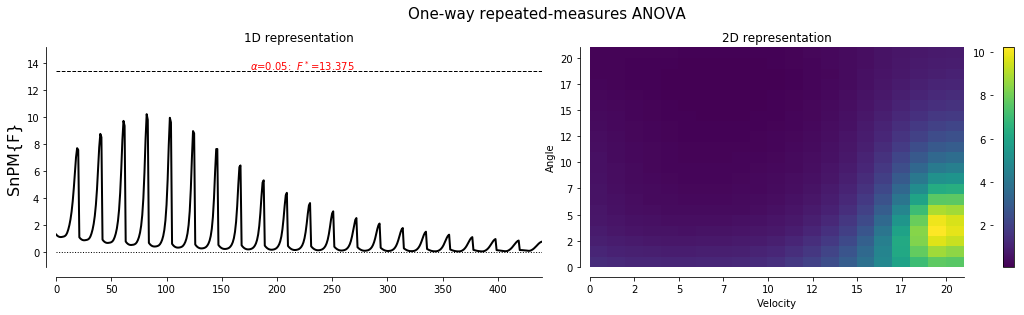

In [5]:
alpha = 0.05
a_spm = spm1d.stats.nonparam.anova1rm(y, positions, participants)
a_spmi = a_spm.inference(alpha, iterations=100)

title = 'One-way repeated-measures ANOVA'
display_results(a_spmi, drop_non_significative=False, title=title)

## Post hoc analysis (paired t-test)

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  2222.31185
   SPM.h0reject       :  False
   SPM.p              :  ()

[]


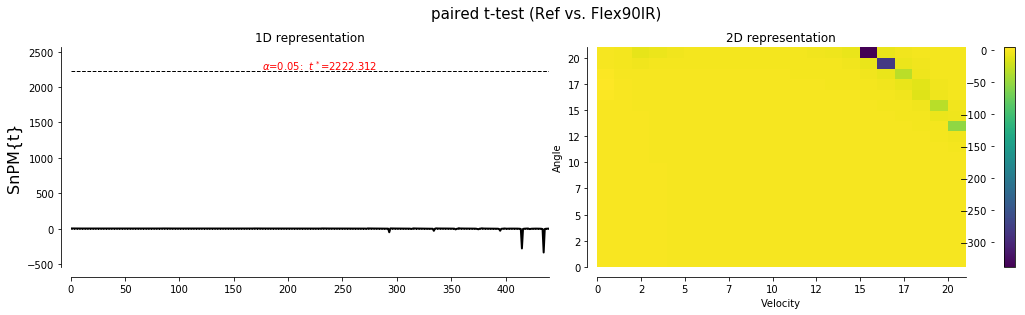

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  86.39960
   SPM.h0reject       :  False
   SPM.p              :  ()

[]


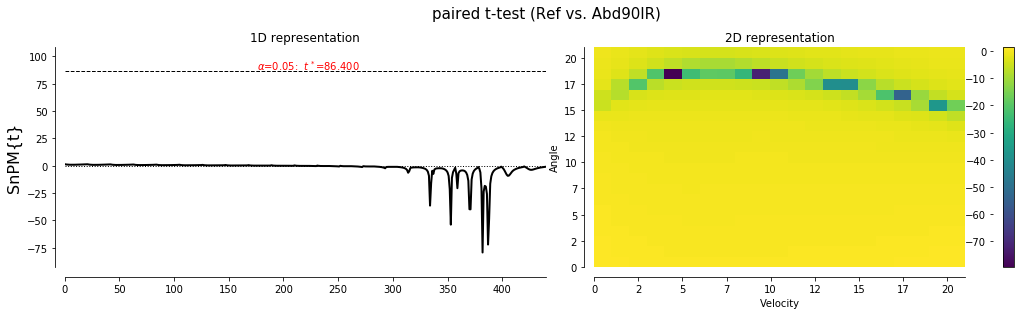

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  287.92758
   SPM.h0reject       :  True
   SPM.p              :  (0.250)

[Cluster (NonParam)
   threshold       :  287.928
   centroid        :  (439.000, 305.023)
   isinterpolated  :  True
   iswrapped       :  False
   endpoints       :  (438.843, 439.158)
   extent          :  0.316
   metric          :  ClusterIntegral
   metric_value    :  51.28713
   nPermUnique     :  4 unique permutations possible
   nPermActual     :  4 actual permutations
   P               :  0.25000

]


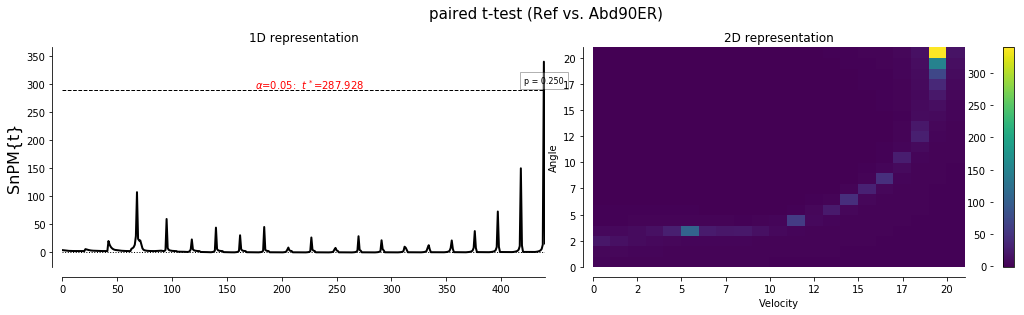

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  2924.20645
   SPM.h0reject       :  False
   SPM.p              :  ()

[]


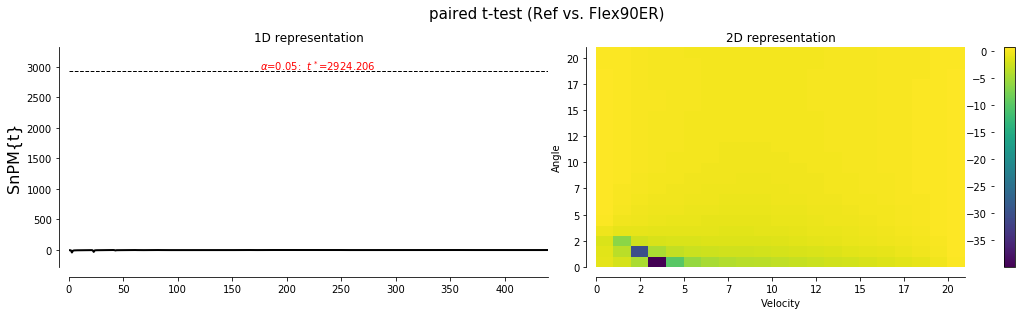

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  363.45126
   SPM.h0reject       :  True
   SPM.p              :  (0.250)

[Cluster (NonParam)
   threshold       :  363.451
   centroid        :  (333.000, 460.744)
   isinterpolated  :  True
   iswrapped       :  False
   endpoints       :  (332.551, 333.450)
   extent          :  0.898
   metric          :  ClusterIntegral
   metric_value    :  291.87776
   nPermUnique     :  4 unique permutations possible
   nPermActual     :  4 actual permutations
   P               :  0.25000

]


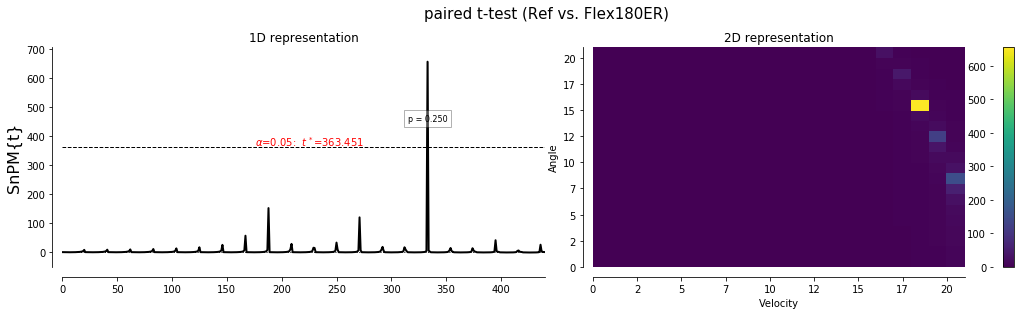

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  501.22187
   SPM.h0reject       :  True
   SPM.p              :  (0.250)

[Cluster (NonParam)
   threshold       :  501.222
   centroid        :  (29.004, 556.040)
   isinterpolated  :  True
   iswrapped       :  False
   endpoints       :  (28.746, 29.266)
   extent          :  0.520
   metric          :  ClusterIntegral
   metric_value    :  164.45354
   nPermUnique     :  4 unique permutations possible
   nPermActual     :  4 actual permutations
   P               :  0.25000

]


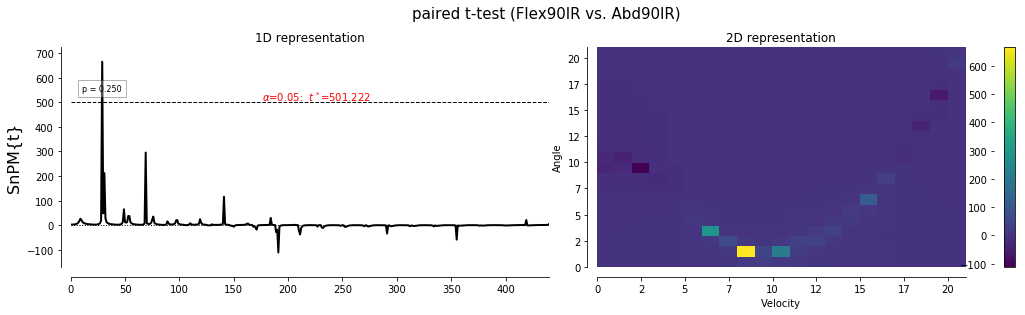

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  693.54798
   SPM.h0reject       :  False
   SPM.p              :  ()

[]


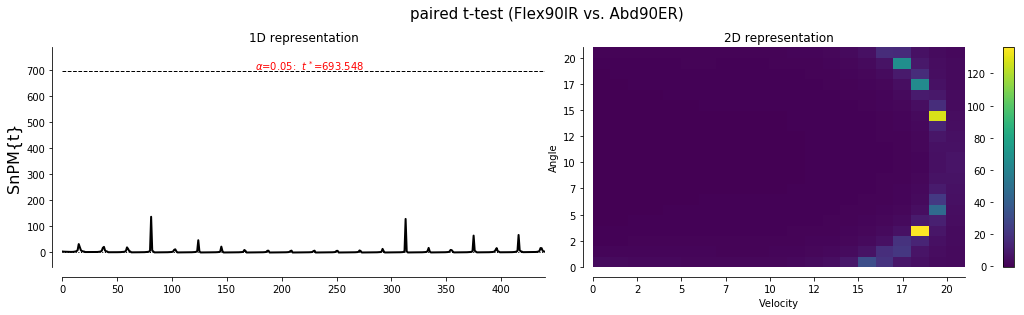

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  46.91868
   SPM.h0reject       :  False
   SPM.p              :  ()

[]


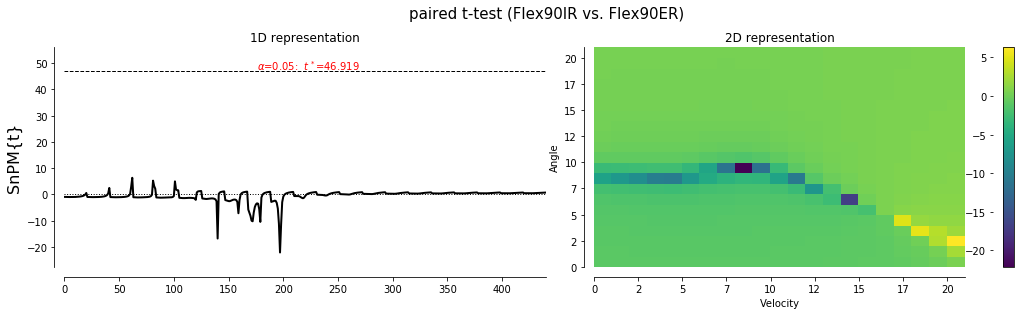

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  1644.50925
   SPM.h0reject       :  True
   SPM.p              :  (0.250)

[Cluster (NonParam)
   threshold       :  1644.509
   centroid        :  (332.000, 2190.806)
   isinterpolated  :  True
   iswrapped       :  False
   endpoints       :  (331.499, 332.501)
   extent          :  1.003
   metric          :  ClusterIntegral
   metric_value    :  1638.88916
   nPermUnique     :  4 unique permutations possible
   nPermActual     :  4 actual permutations
   P               :  0.25000

]


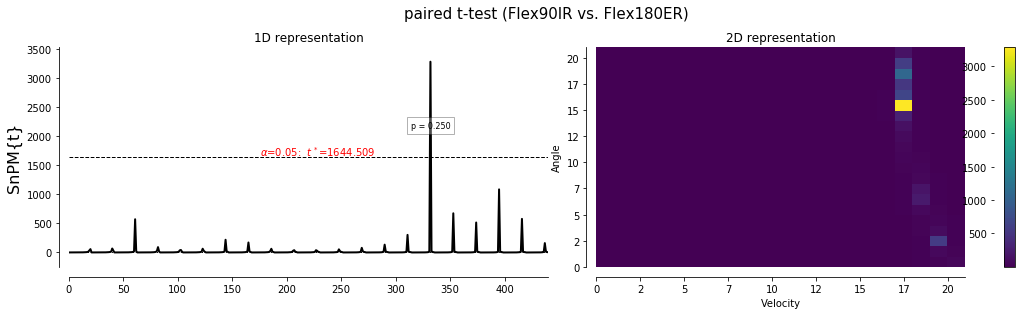

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  1317.15490
   SPM.h0reject       :  False
   SPM.p              :  ()

[]


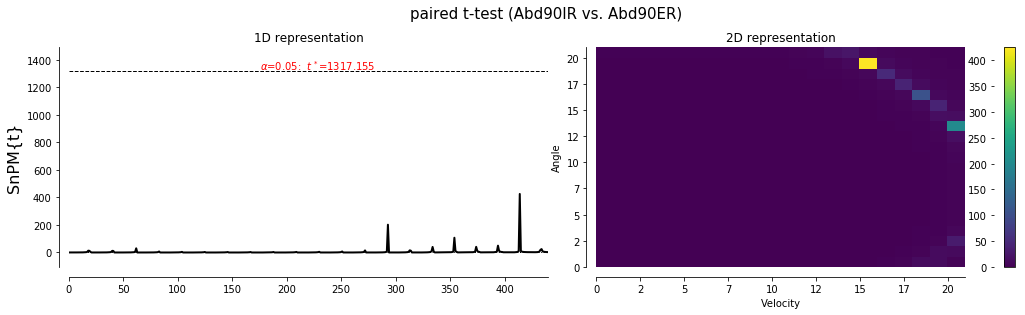

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  196.69888
   SPM.h0reject       :  False
   SPM.p              :  ()

[]


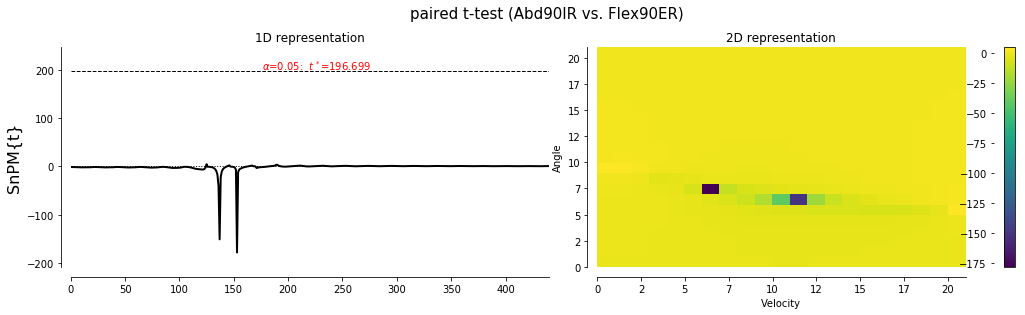

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  152.91099
   SPM.h0reject       :  True
   SPM.p              :  (0.250, 0.250, 0.250)

[Cluster (NonParam)
   threshold       :  152.911
   centroid        :  (164.000, 200.548)
   isinterpolated  :  True
   iswrapped       :  False
   endpoints       :  (163.501, 164.500)
   extent          :  0.999
   metric          :  ClusterIntegral
   metric_value    :  142.91043
   nPermUnique     :  4 unique permutations possible
   nPermActual     :  4 actual permutations
   P               :  0.25000

, Cluster (NonParam)
   threshold       :  152.911
   centroid        :  (185.001, 169.566)
   isinterpolated  :  True
   iswrapped       :  False
   endpoints       :  (184.742, 185.260)
   extent          :  0.518
   metric          :  ClusterIntegral
   metric_value    :  49.96519
   nPermUnique     : 

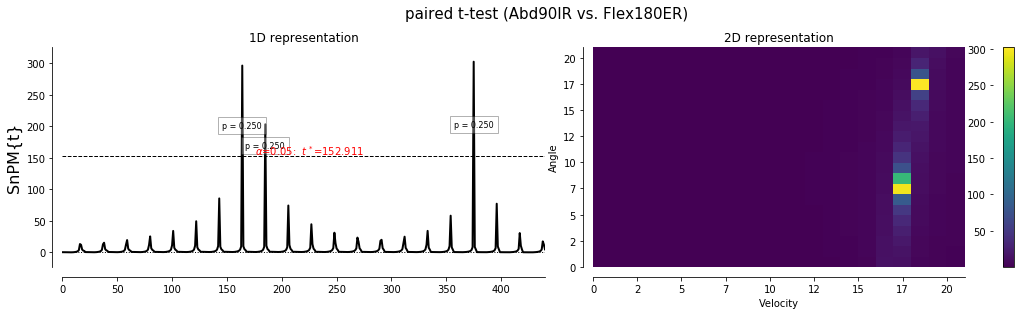

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  5569.68040
   SPM.h0reject       :  False
   SPM.p              :  ()

[]


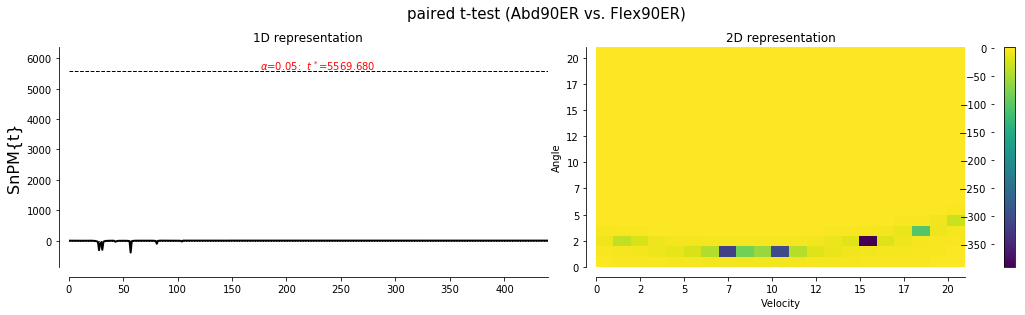

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  760.48584
   SPM.h0reject       :  False
   SPM.p              :  ()

[]


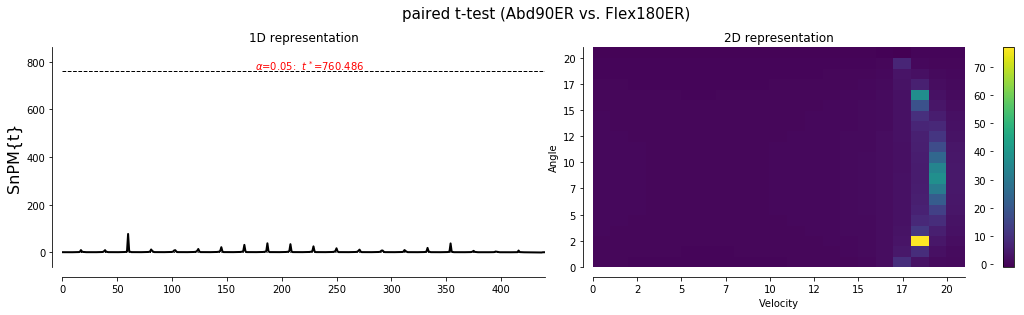

SnPM{T} inference field
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  356.01196
   SPM.h0reject       :  True
   SPM.p              :  (0.250)

[Cluster (NonParam)
   threshold       :  356.012
   centroid        :  (203.000, 381.253)
   isinterpolated  :  True
   iswrapped       :  False
   endpoints       :  (202.821, 203.179)
   extent          :  0.357
   metric          :  ClusterIntegral
   metric_value    :  75.72250
   nPermUnique     :  4 unique permutations possible
   nPermActual     :  4 actual permutations
   P               :  0.25000

]


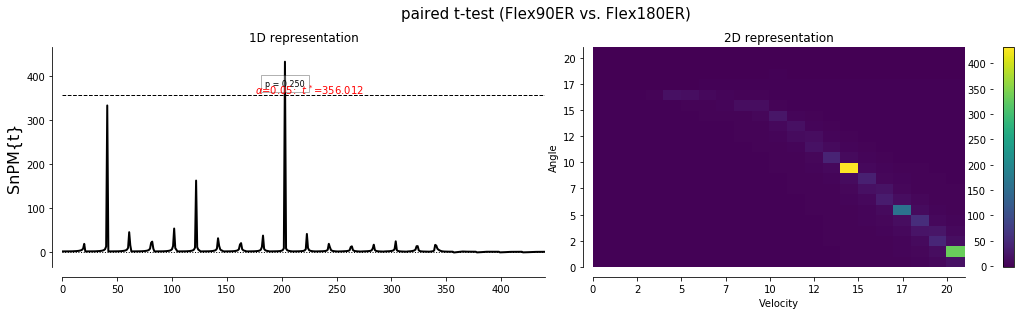

In [6]:
n_positions = len(set(positions))
name_positions = list(torque.keys())
combinations = itertools.combinations(range(1, n_positions+1), 2)


for A, B in combinations:
    yA = y[positions == A]
    yB = y[positions == B]

    alpha = 0.05
    t_spm = spm1d.stats.nonparam.ttest_paired(yA, yB)
    t_spmi = t_spm.inference(alpha, two_tailed=False, iterations=-1)
    
    title = 'paired t-test ({} vs. {})'.format(name_positions[A-1], name_positions[B-1])
    display_results(t_spmi, drop_non_significative=False, title=title)